### imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import style
style.use("ggplot")
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix

### data-preparation

### see the last Cell to view the last version


In [4]:
def nat_check(nat):
    #print(nat)
    #print(np.datetime64('NaT'))
    #print(nat)
    return (nat is not np.nat)  

In [5]:
rowDates = []
rowValues = []
counter = 0

#dataDF = pd.read_csv('CW PUMP 1B CURRENT.csv', sep=',', header=None)  
#dataDF = pd.read_csv('ID FAN 1B MTR OBRG TEMP.csv', sep=',', header=None)   # outlier > 90 and < 10
dataDF = pd.read_csv('temperator.csv', sep=',', header=None)                # outlier > 100 and < 0  outlierRange = [100, 0]
#dataDF = pd.read_csv('drehzahl.csv', sep=',', header=None)                   
#dataDF = pd.read_csv('Durchflussmessung(ls).csv', sep=',', header=None)                   
#dataDF = pd.read_csv('Wirkleistung(MW)).csv', sep=',', header=None)                   
#dataDF = pd.read_csv('NspPrressure.csv', sep=',', header=None)                   

#dataDF = pd.read_csv('9-1-2008 to 9-1-2009 Trend.csv', sep=',', header=None)  

for index, row in dataDF.iterrows():
    rowValue = row[1]
    rowDate = row[0]
        
    try:
        float(rowValue)
        pd.to_datetime(rowDate)
        rowValues.append(float(rowValue))
        rowDates.append(pd.to_datetime(rowDate))
        #rowDates.append(pd.to_datetime(rowDate).timestamp())
        #print(rowValues)
        #print(rowDates)
        #break
    except:
        counter += 1
        continue
    
    if index == 2000:
        break

print('values :',len(rowValues))
print('dates :',len(rowDates))
print('invalid :',counter)

#print(rowDates)

values : 1998
dates : 1998
invalid : 3


In [6]:
def createAnomalyList(values, interval):
    counterNew = 0
    outlier = []
    for v in values:
        if (v < interval[0] or v > interval[1]):
            #print(v)
            outlier.append(1)
            counterNew = counterNew + 1
        else:
            outlier.append(0)
    print("anomalie :", counterNew)
    return outlier

In [7]:
def plotTheDataWithoutClusters(x, predicted, rowValues, rowDates, titel):
    print("without cluster : " , x )
    counterProCluster = 0
    clusterVal = []
    clusterDate = []
    predictedNew = []

    for i in range(len(predicted)):
        if(predicted[i] != x):
            counterProCluster = counterProCluster + 1
            clusterVal.append(rowValues[i])
            clusterDate.append(rowDates[i])
            predictedNew.append(predicted[i])
        else:
            continue

    fig, (ax1) = plt.subplots(1, figsize=(14,6))
    ax1.scatter(clusterDate, clusterVal , c = predictedNew)
    ax1.set_xlabel("$Time$")
    ax1.set_ylabel("$Value$")
    ax1.set_title(titel)
    plt.show()

In [8]:
def movingaverage (values, dates , window):
    weights = np.repeat(1.0, window)/window

    sma = np.convolve(values, weights, 'valid')
    window = window - 1
    

    newlist = dates[window:]
    

    return sma, newlist
 

In [9]:
def calculateDelta(values, dates):
    deltaDates = dates.copy()
    del deltaDates[0]
    delta = []
    posDelta = []

    for idx in range(1, len(values)):
        x = values[idx] - values[idx - 1]
        delta.append(x)
        if(x < 0):
            posDelta.append(-1*x)
        else:
            posDelta.append(x)
            
    print("delta Values: ", len(delta))
    print("pos delta Values: ", len(posDelta))
    print("delta Dates: ", len(deltaDates))

    return delta, posDelta, deltaDates

In [10]:
def plotTheclusteredData(dates, values, labels):
    fig, (ax1) = plt.subplots(1, figsize=(14,6))
    ax1.scatter(dates, values , c=labels.astype(np.float))
    ax1.set_xlabel("$Time$")
    ax1.set_ylabel("$Value$")
    ax1.set_title("$K-Means original$")
    plt.show()

In [11]:
def plotTheElbow(K, distortions):
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [12]:
def calculateAccuracy(cm):
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy

In [13]:
def calculateError(cm):
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    error = (fp + fn) / (tp + tn + fp + fn)
    return error

In [14]:
def calculateRecall(cm):
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    recall = tp / (tp + fn)
    return recall

In [15]:
def calculatePrecision(cm):
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    precision = tp / (tp + fp)
    return precision

In [16]:
def optimalFound(deltas, k):
    found = 0
    for idx in range(1,len(deltas)):       
        if(deltas[idx] < deltas[idx-1]):
            found = True
            return found
            break
        else:
            continue

In [17]:
def getVarianceDelta(distortions):
    deltas = []
    for ind in range(1, len(distortions)):
        deltas.append(abs(distortions[ind] - distortions[ind-1]))
    return deltas

In [18]:
def mergeClusters(resultClusters):
    merged = [0] * len(resultClusters[0])
    for cluster in resultClusters:
        for i in range(0, len(cluster)-1):
            if(cluster[i] == 1):
                merged[i] = 1            
    return merged

        

In [19]:
outlierRange = [0, 100]
outlierRangeDel = [-1, 30]
window = 20
#valuesAv, datesAv = movingaverage(rowValues, rowDates, window)
#outlier = createAnomalyList(valuesAv, outlierRange)
outlier = createAnomalyList(rowValues, outlierRange)
deltaValues, posDeltaValues, deltaDates = calculateDelta(rowValues, rowDates)
outlierDelta = createAnomalyList(posDeltaValues, outlierRangeDel)
outlierPosDelta = createAnomalyList(posDeltaValues, outlierRangeDel)

anomalie : 3
delta Values:  1997
pos delta Values:  1997
delta Dates:  1997
anomalie : 6
anomalie : 6


### plot the rawData

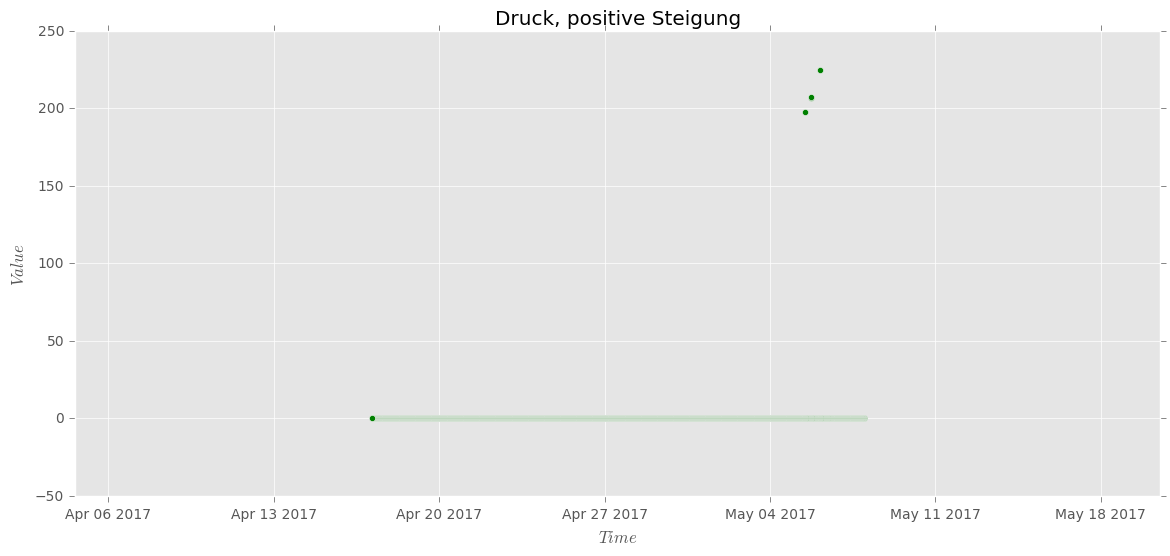

In [20]:
fig, (ax1) = plt.subplots(1, figsize=(14,6))

#ax1.scatter(datesAv, valuesAv, c="green")
#ax1.scatter(rowDates, rowValues, c="green")

#ax1.scatter(deltaDates, deltaValues, c="red")
ax1.scatter(deltaDates, posDeltaValues, c="green")


ax1.set_xlabel("$Time$")
ax1.set_ylabel("$Value$")

ax1.set_title("Druck, positive Steigung")
plt.show()

### K means for original 

k =  2
no optimal cluster found
--------
k =  3
no optimal cluster found
--------
k =  4
no optimal cluster found
--------
k =  5
0.28178178178178176 of the observations are in cluster:  0  ==> not less than 0.005
0.28178178178178176 of the observations are in cluster:  1  ==> not less than 0.005
num of data points in cluster 306  :  3        percent:  0.0015015015015015015
[[1995    0]
 [   0    3]]
precision :  1.0
recall    :  1.0
the Anomaly Cluster is the one which contains  3 observations
-------------------------------------------------


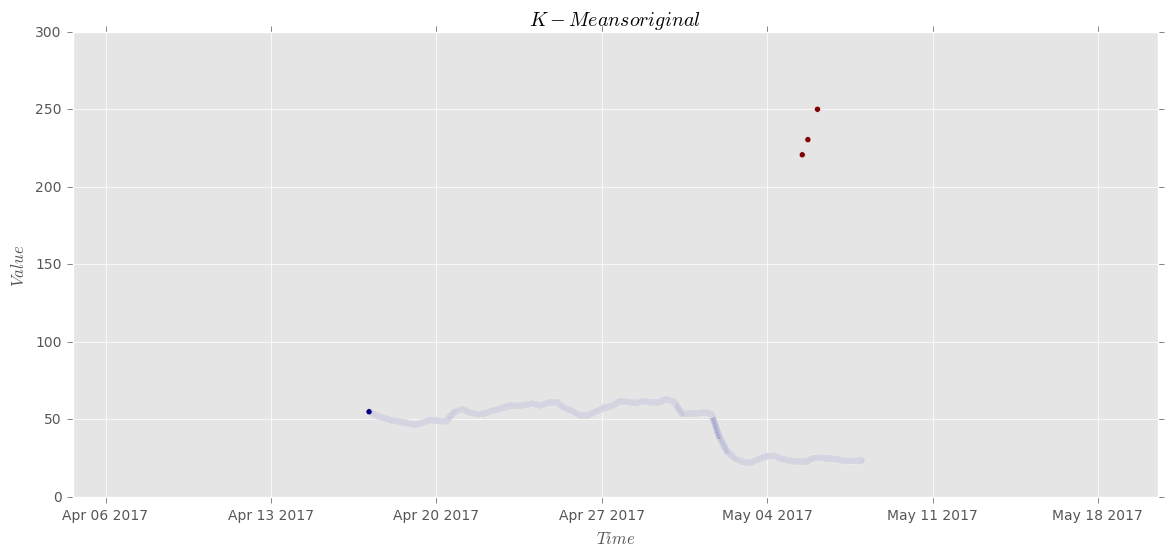

0.28178178178178176 of the observations are in cluster:  3  ==> not less than 0.005
0.15315315315315314 of the observations are in cluster:  4  ==> not less than 0.005
--------


In [29]:
# k means Original finished
distortions = []
varDelta = []
K = range(2,9)
K_delta = range(K[0]+1,K[len(K)-1]+1)

values = np.asarray(rowValues).reshape(-1, 1)
dates = np.asarray(rowDates)
outlierList = outlier
#--------------- 
datesDisplay = rowDates.copy()
valuesDisplay = rowValues.copy()
del datesDisplay[0]
del valuesDisplay[0]
#---------------

counter = 0    
for k in K:
    print("k = ", k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), 
                                        kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])  
    varDelta = getVarianceDelta(distortions)
    
    if(optimalFound(varDelta, k)):
        found = optimalFound(varDelta, k)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        labelsNew = list(labels) 
        counts = []
        outlierValuesPredictedCluster = []
        
        
        for cluster in range(0,k):
            counter = 0
            outlierValuesPredicted = []
            for label in (labels):
                if (cluster == label):
                    counter = counter + 1
                    outlierValuesPredicted.append(1)
                else:
                    outlierValuesPredicted.append(0)
                    continue
            counts.append(counter)
            outlierValuesPredictedCluster.append(outlierValuesPredicted)
        resultClusters = []
        clusterIndex = -1
        
        for count in counts:
            clusterIndex = clusterIndex + 1

            if(count/len(values) < 0.005):
                resultClusters.append(outlierValuesPredictedCluster[clusterIndex])
                print('num of data points in cluster', counter ,' : ', counts[clusterIndex],'       percent: ' ,  counts[clusterIndex]/len(values)) 
                #print("centroids " , ":" , centroids[counts.index(count)])
                cm = confusion_matrix(outlierList, outlierValuesPredictedCluster[clusterIndex])
                print(cm)
                #acc = calculateAccuracy(cm)
                #err = calculateError(cm)
                precision = calculatePrecision(cm)
                recall = calculateRecall(cm)
                print("precision : ", precision)
                print("recall    : " ,recall)
                #print("Accuracy : ", acc)
                #print("Error    : " ,err)
                print("the Anomaly Cluster is the one which contains ", count, "observations")

                print("-------------------------------------------------")
                plotTheclusteredData(dates, values, np.asarray(outlierValuesPredictedCluster[clusterIndex]))
            else:
                print(count/len(values),"of the observations are in cluster: ", clusterIndex, " ==> not less than 0.005")
                continue
    
        if(len(resultClusters)>1):
            print("all the found clusters merged together")
            merged = mergeClusters(resultClusters)
            cm = confusion_matrix(outlierList, merged)
            print(cm)
            precision = calculatePrecision(cm)
            recall = calculateRecall(cm)
            print("precision : ", precision)
            print("recall    : " ,recall)  
            
            plotTheclusteredData(datesDisplay, valuesDisplay, np.asarray(merged))
        print("--------")
        break
    else:
        print("no optimal cluster found")
        print("--------")

    


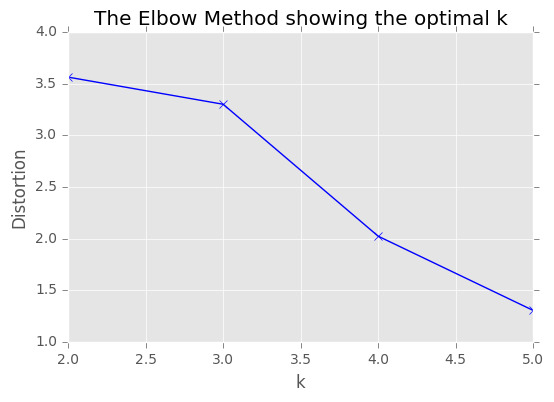

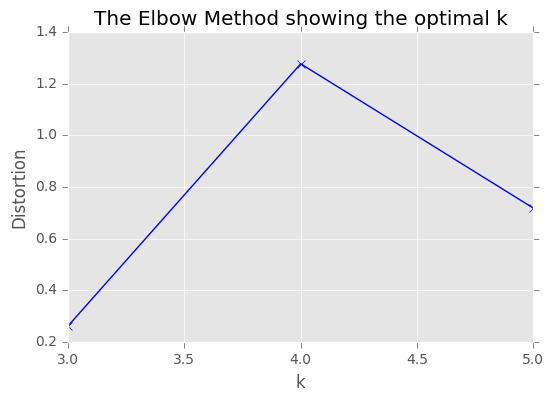

In [30]:
plotTheElbow(range(K[0], k+1), distortions)
plotTheElbow(range(K[1], k+1), varDelta)

k =  2
no optimal cluster found
--------
k =  3
no optimal cluster found
--------
k =  4
0.9969954932398598 of the observations are in cluster:  0  ==> not less than 0.005
num of data points in cluster 2  :  2        percent:  0.00100150225338007
[[1991    0]
 [   4    2]]
precision :  1.0
recall    :  0.997994987469
the Anomaly Cluster is the one which contains  2 observations
-------------------------------------------------


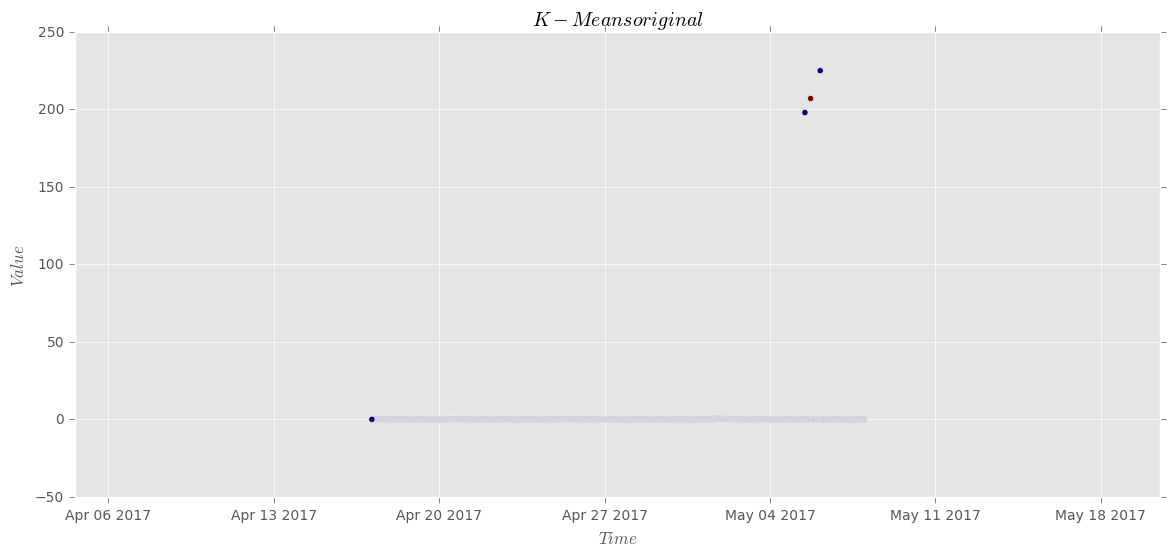

num of data points in cluster 2  :  2        percent:  0.00100150225338007
[[1991    0]
 [   4    2]]
precision :  1.0
recall    :  0.997994987469
the Anomaly Cluster is the one which contains  2 observations
-------------------------------------------------


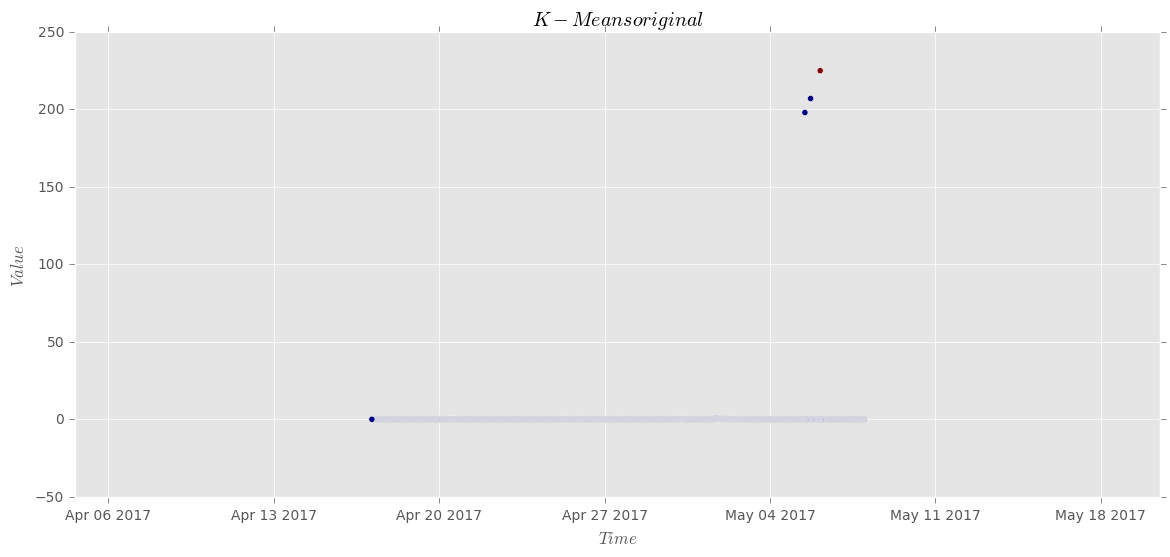

num of data points in cluster 2  :  2        percent:  0.00100150225338007
[[1991    0]
 [   4    2]]
precision :  1.0
recall    :  0.997994987469
the Anomaly Cluster is the one which contains  2 observations
-------------------------------------------------


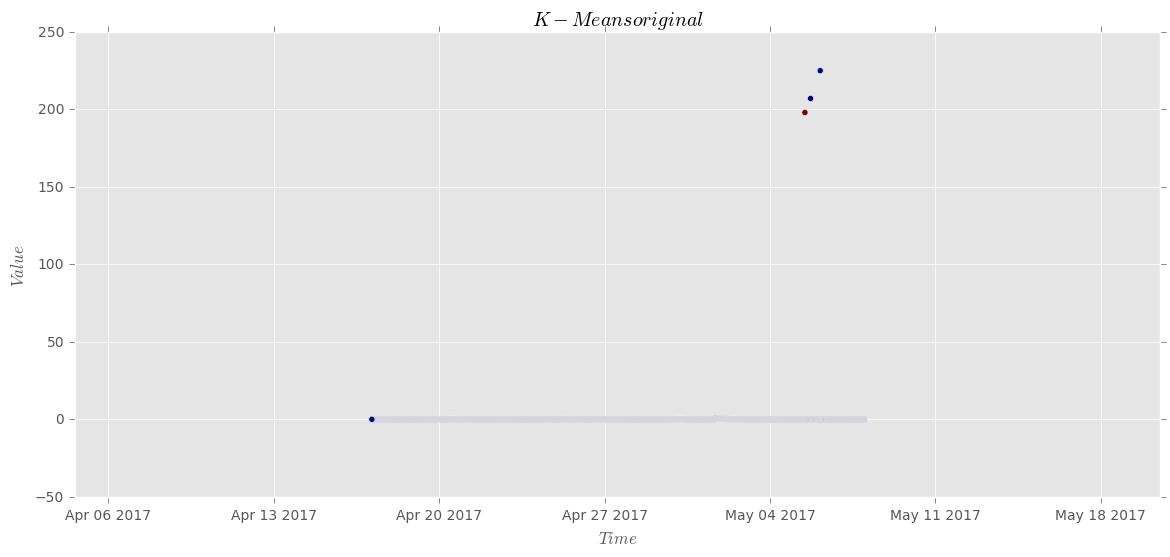

all the found clusters merged together
[[1991    0]
 [   0    6]]
precision :  1.0
recall    :  1.0


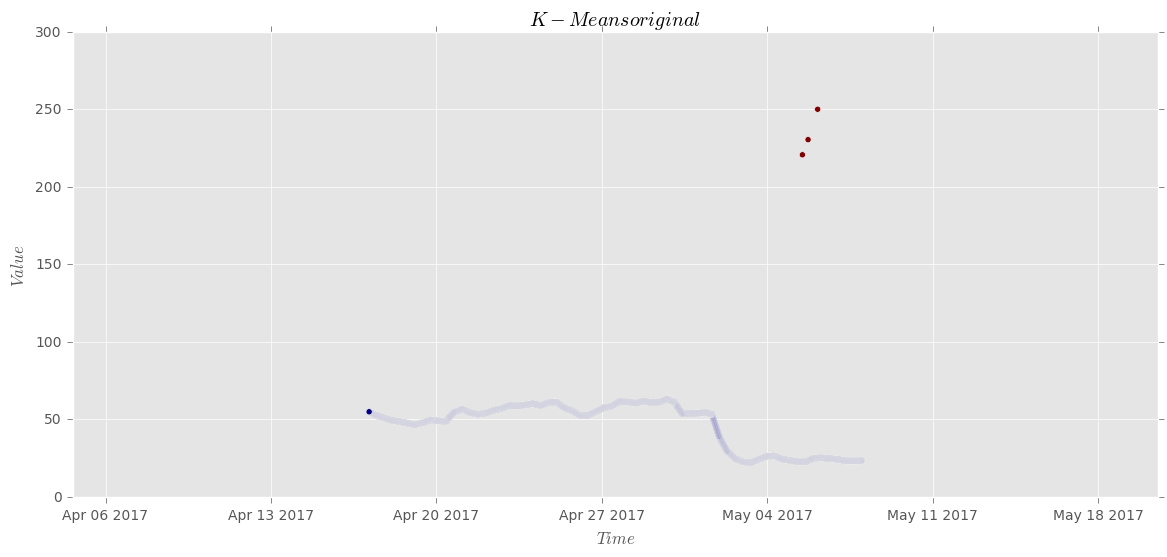

--------


In [31]:
# k-means Delta finished
distortions = []
varDelta = []
K = range(2,9)
K_delta = range(K[0]+1,K[len(K)-1]+1)

values = np.asarray(posDeltaValues).reshape(-1, 1)
dates = np.asarray(deltaDates)
outlierList = outlierPosDelta
#--------------- 
datesDisplay = rowDates.copy()
valuesDisplay = rowValues.copy()
del datesDisplay[0]
del valuesDisplay[0]
#---------------

counter = 0    
for k in K:
    print("k = ", k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), 
                                        kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])  
    varDelta = getVarianceDelta(distortions)
    
    if(optimalFound(varDelta, k)):
        found = optimalFound(varDelta, k)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        labelsNew = list(labels) 
        counts = []
        outlierValuesPredictedCluster = []
        
        
        for cluster in range(0,k):
            counter = 0
            outlierValuesPredicted = []
            for label in (labels):
                if (cluster == label):
                    counter = counter + 1
                    outlierValuesPredicted.append(1)
                else:
                    outlierValuesPredicted.append(0)
                    continue
            counts.append(counter)
            outlierValuesPredictedCluster.append(outlierValuesPredicted)
        
        resultClusters = []
        clusterIndex = -1
        
        for count in counts:
            clusterIndex = clusterIndex + 1

            if(count/len(values) < 0.005):
                resultClusters.append(outlierValuesPredictedCluster[clusterIndex])
                print('num of data points in cluster', counter ,' : ', counts[clusterIndex],'       percent: ' ,  counts[clusterIndex]/len(values)) 
                #print("centroids " , ":" , centroids[counts.index(count)])
                cm = confusion_matrix(outlierList, outlierValuesPredictedCluster[clusterIndex])
                print(cm)
                #acc = calculateAccuracy(cm)
                #err = calculateError(cm)
                precision = calculatePrecision(cm)
                recall = calculateRecall(cm)
                print("precision : ", precision)
                print("recall    : " ,recall)
                #print("Accuracy : ", acc)
                #print("Error    : " ,err)
                print("the Anomaly Cluster is the one which contains ", count, "observations")

                print("-------------------------------------------------")
                plotTheclusteredData(dates, values, np.asarray(outlierValuesPredictedCluster[clusterIndex]))
            else:
                print(count/len(values),"of the observations are in cluster: ", clusterIndex, " ==> not less than 0.005")
                continue
    
        if(len(resultClusters)>1):
            print("all the found clusters merged together")
            merged = mergeClusters(resultClusters)
            cm = confusion_matrix(outlierList, merged)
            print(cm)
            precision = calculatePrecision(cm)
            recall = calculateRecall(cm)
            print("precision : ", precision)
            print("recall    : " ,recall)            

            plotTheclusteredData(datesDisplay, valuesDisplay, np.asarray(merged))
        print("--------")
        break
    else:
        print("no optimal cluster found")
        print("--------")

    


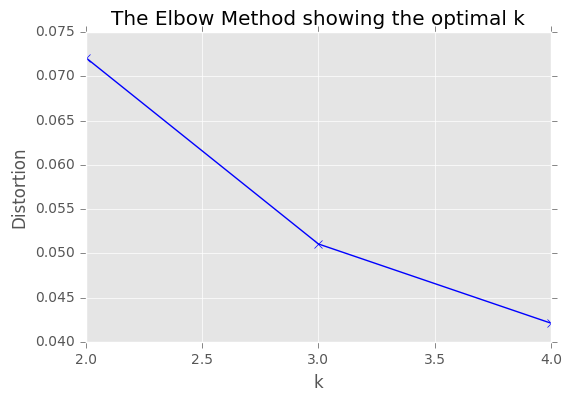

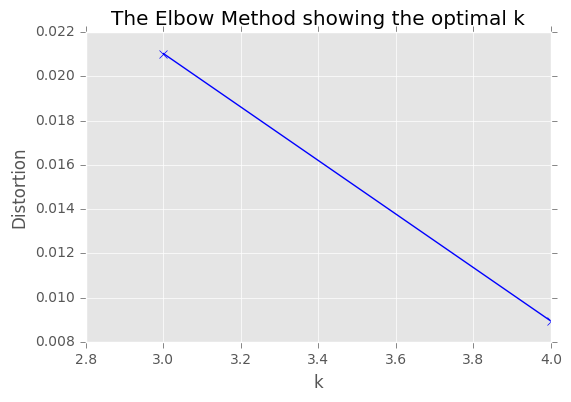

In [32]:
plotTheElbow(range(K[0], k+1), distortions)
plotTheElbow(range(K[1], k+1), varDelta)



k =  2
no optimal cluster found
--------
k =  3
no optimal cluster found
--------
k =  4
centroids  : [ 207.59999885]
num of data points in cluster 1  :  10        percent:  0.000500175061271445
[[19977     0]
 [    6    10]]
Accuracy :  0.999699894963
Error    :  0.000300105036763
-------------------------------------------------
the Anomaly Cluster is the one which contains  10 observations


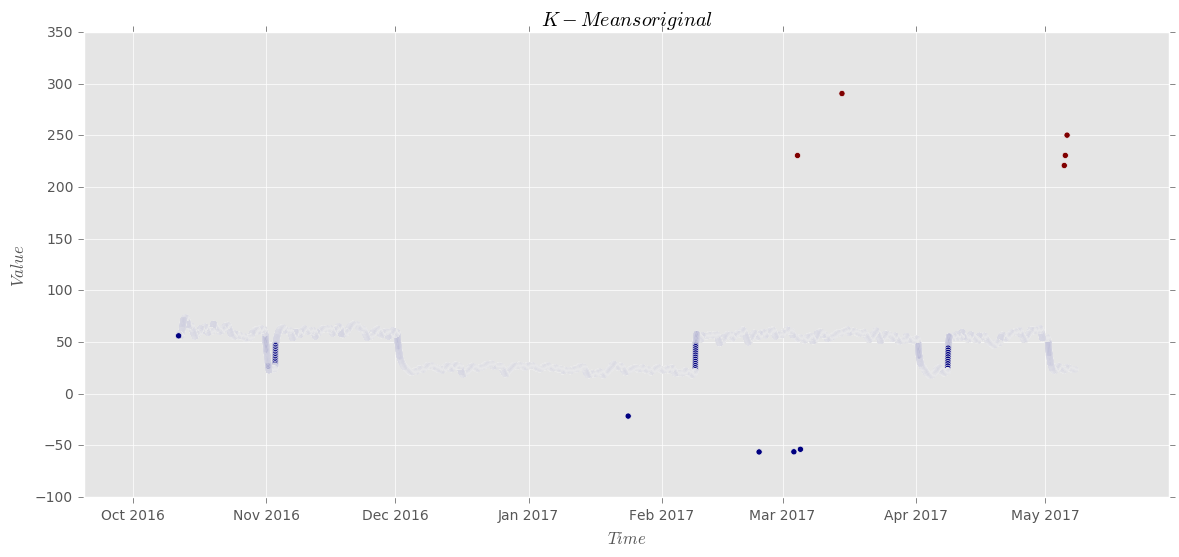

centroids  : [ 111.07952817]
num of data points in cluster 2  :  6        percent:  0.000300105036762867
[[19977     0]
 [   10     6]]
Accuracy :  0.999499824939
Error    :  0.000500175061271
-------------------------------------------------
the Anomaly Cluster is the one which contains  6 observations


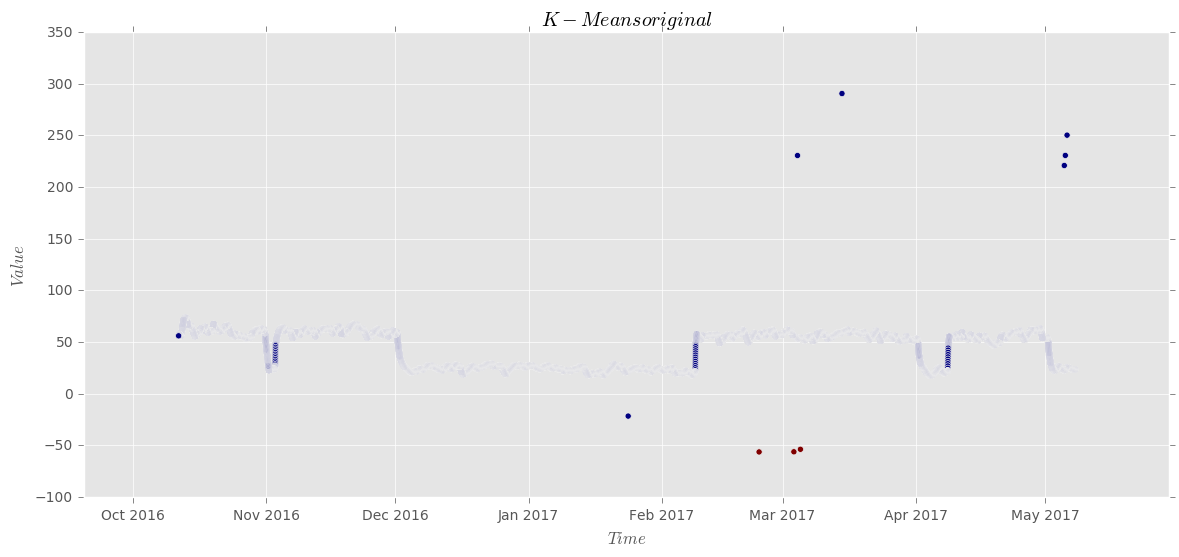

centroids  : [ 43.50143432]
num of data points in cluster 3  :  2        percent:  0.000100035012254289
[[19975     2]
 [   16     0]]
Accuracy :  0.99909968489
Error    :  0.000900315110289
-------------------------------------------------
the Anomaly Cluster is the one which contains  2 observations


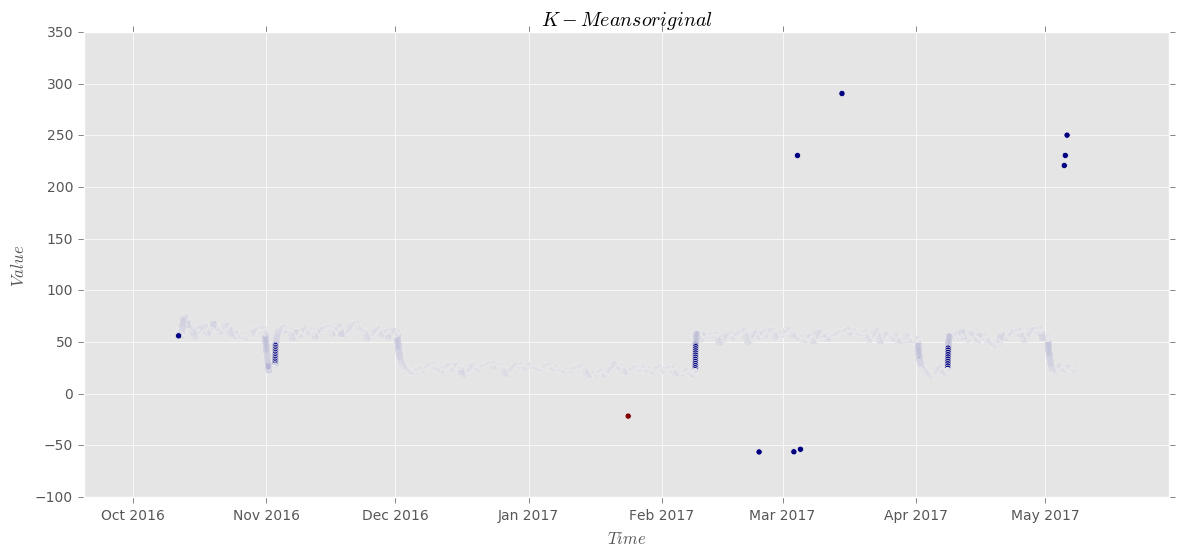

all the found clusters merged together


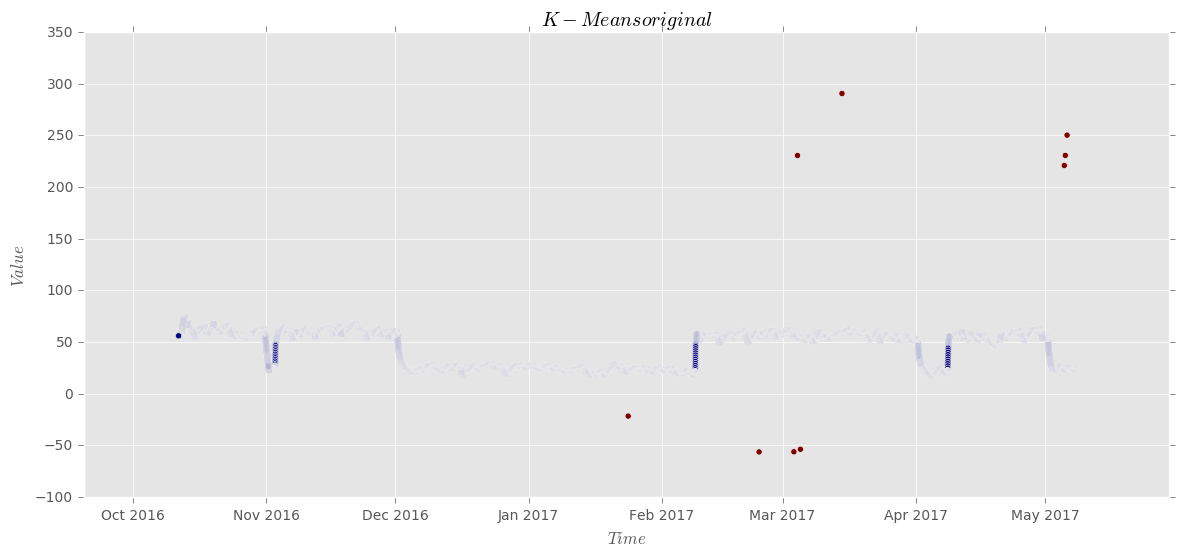

k =  5
centroids  : [ 193.99999904]
num of data points in cluster 1  :  6        percent:  0.000300105036762867
[[19977     0]
 [   10     6]]
Accuracy :  0.999499824939
Error    :  0.000500175061271
-------------------------------------------------
the Anomaly Cluster is the one which contains  6 observations


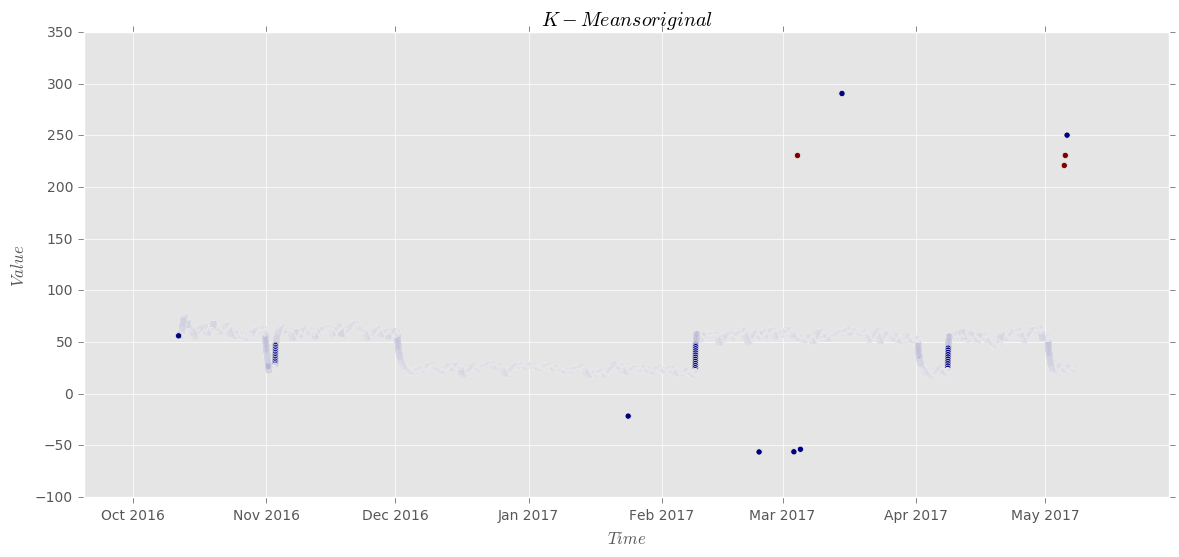

centroids  : [ 193.99999904]
num of data points in cluster 1  :  6        percent:  0.000300105036762867
[[19977     0]
 [   10     6]]
Accuracy :  0.999499824939
Error    :  0.000500175061271
-------------------------------------------------
the Anomaly Cluster is the one which contains  6 observations


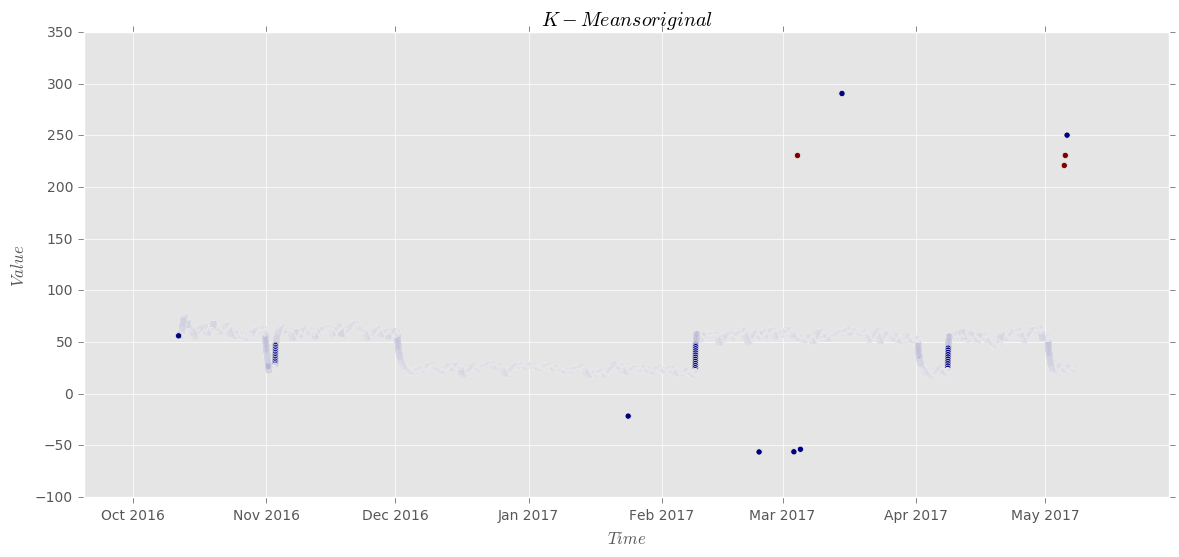

centroids  : [ 43.50143432]
num of data points in cluster 3  :  2        percent:  0.000100035012254289
[[19975     2]
 [   16     0]]
Accuracy :  0.99909968489
Error    :  0.000900315110289
-------------------------------------------------
the Anomaly Cluster is the one which contains  2 observations


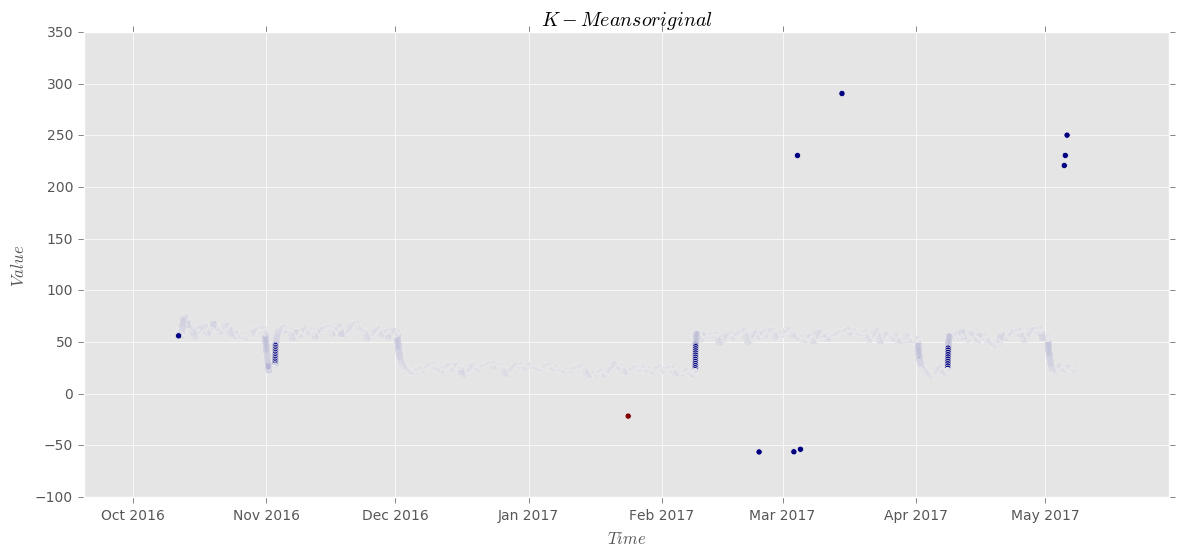

centroids  : [ 227.99999856]
num of data points in cluster 4  :  4        percent:  0.000200070024508578
[[19977     0]
 [   12     4]]
Accuracy :  0.999399789926
Error    :  0.000600210073526
-------------------------------------------------
the Anomaly Cluster is the one which contains  4 observations


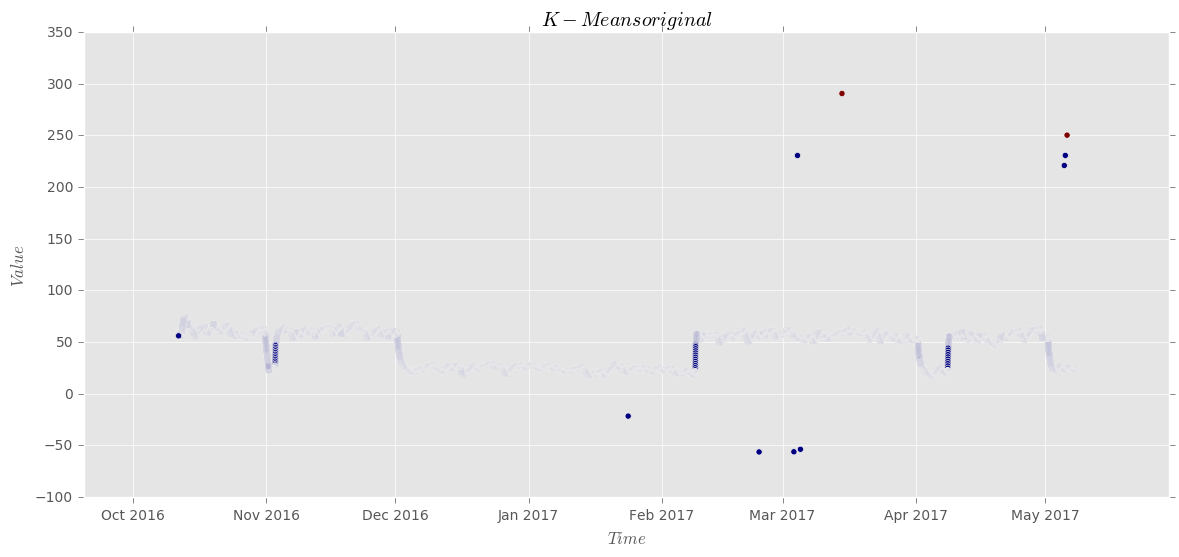

all the found clusters merged together


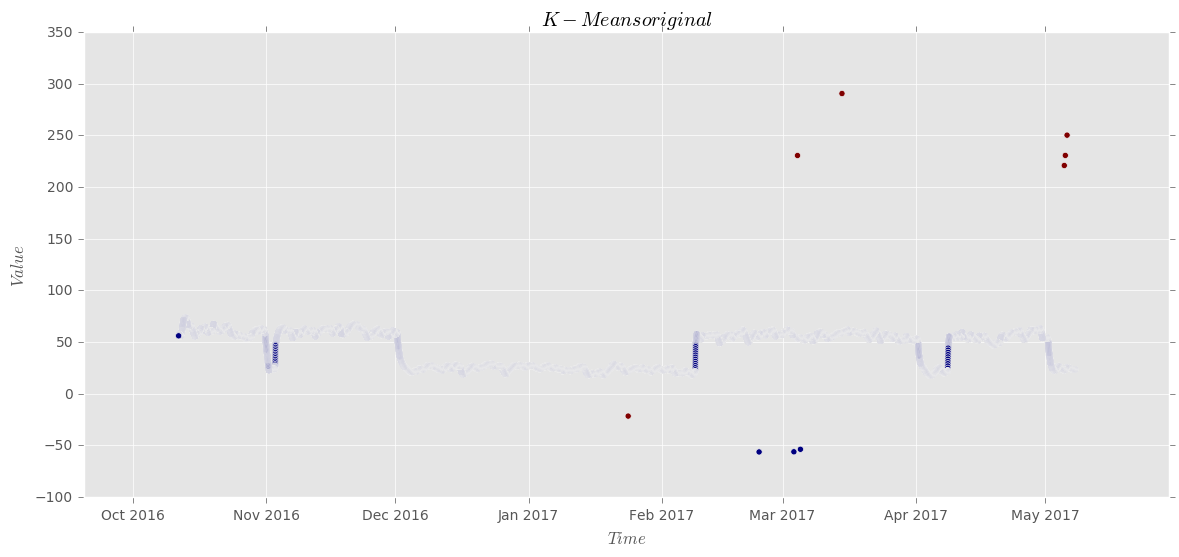

k =  6
centroids  : [ 176.99999809]
num of data points in cluster 1  :  2        percent:  0.000100035012254289
[[19977     0]
 [   14     2]]
Accuracy :  0.999299754914
Error    :  0.00070024508578
-------------------------------------------------
the Anomaly Cluster is the one which contains  2 observations


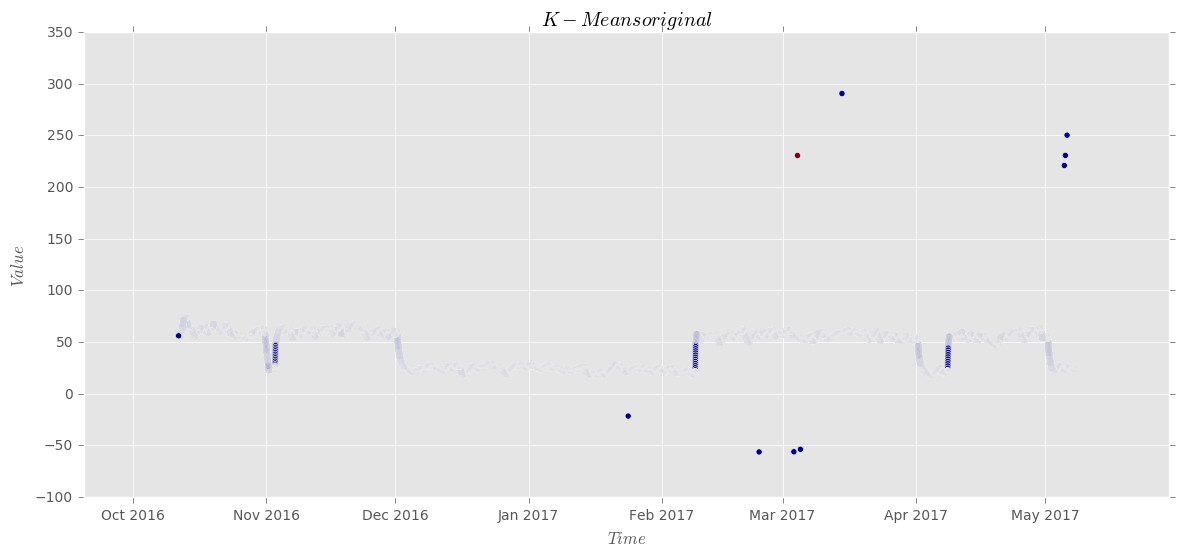

centroids  : [ 111.07952817]
num of data points in cluster 2  :  6        percent:  0.000300105036762867
[[19977     0]
 [   10     6]]
Accuracy :  0.999499824939
Error    :  0.000500175061271
-------------------------------------------------
the Anomaly Cluster is the one which contains  6 observations


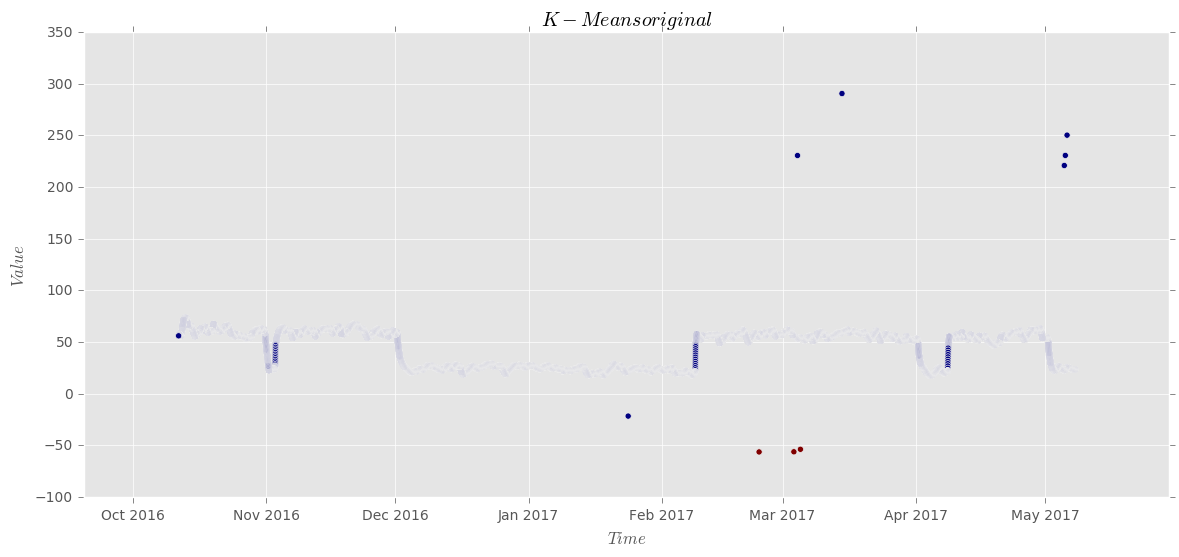

centroids  : [ 227.99999856]
num of data points in cluster 3  :  4        percent:  0.000200070024508578
[[19977     0]
 [   12     4]]
Accuracy :  0.999399789926
Error    :  0.000600210073526
-------------------------------------------------
the Anomaly Cluster is the one which contains  4 observations


KeyboardInterrupt: 

In [301]:
# k means positiv delta 
distortions = []
varDelta = []
K = range(2,9)
K_delta = range(K[0]+1,K[len(K)-1]+1)

values = np.asarray(posDeltaValues).reshape(-1, 1)
dates = np.asarray(deltaDates)
outlierList = outlierPosDelta
datesDisplay = rowDates.copy()
valuesDisplay = rowValues.copy()
del datesDisplay[0]
del valuesDisplay[0]

counter = 0    
for k in K:
    print("k = ", k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), 
                                        kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])  
    varDelta = getVarianceDelta(distortions)
    
    if(optimalFound(varDelta, k)):
        found = optimalFound(varDelta, k)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        labelsNew = list(labels) 
        counts = []
        outlierValuesPredictedCluster = []
        
        
        for cluster in range(0,k):
            counter = 0
            outlierValuesPredicted = []
            for label in (labels):
                if (cluster == label):
                    counter = counter + 1
                    outlierValuesPredicted.append(1)
                else:
                    outlierValuesPredicted.append(0)
                    continue
            counts.append(counter)
            outlierValuesPredictedCluster.append(outlierValuesPredicted)
        resultClusters = []
        for count in counts:
            if(count/len(values) < 0.005):
                resultClusters.append(outlierValuesPredictedCluster[counts.index(count)])
                print("centroids " , ":" , centroids[counts.index(count)])
                print('num of data points in cluster', counts.index(count) ,' : ', counts[counts.index(count)],'       percent: ' ,  counts[counts.index(count)]/len(values)) 
                cm = confusion_matrix(outlierList, outlierValuesPredictedCluster[counts.index(count)])
                print(cm)
                acc = calculateAccuracy(cm)
                err = calculateError(cm)
                print("Accuracy : ", acc)
                print("Error    : " ,err)
                print("-------------------------------------------------")
                print("the Anomaly Cluster is the one which contains ", count, "observations")
                plotTheclusteredData(datesDisplay, valuesDisplay, np.asarray(outlierValuesPredictedCluster[counts.index(count)]))

            else:
                continue
        
        if(len(resultClusters)>1):
            print("all the found clusters merged together")
            merged = mergeClusters(resultClusters)
            plotTheclusteredData(datesDisplay, valuesDisplay, np.asarray(merged))

    else:
        print("no optimal cluster found")
        print("--------")

    



k =  2
centroids  : [ 57.6461693]
num of data points in cluster 0  :  11949        percent:  0.597629288786636
[[ 8041 11944]
 [    4     5]]
Accuracy :  0.402420726218
Error    :  0.597579273782
-------------------------------------------------
centroids  : [ 23.95922289]
num of data points in cluster 1  :  8045        percent:  0.402370711213364
[[11944  8041]
 [    5     4]]
Accuracy :  0.597579273782
Error    :  0.402420726218
-------------------------------------------------


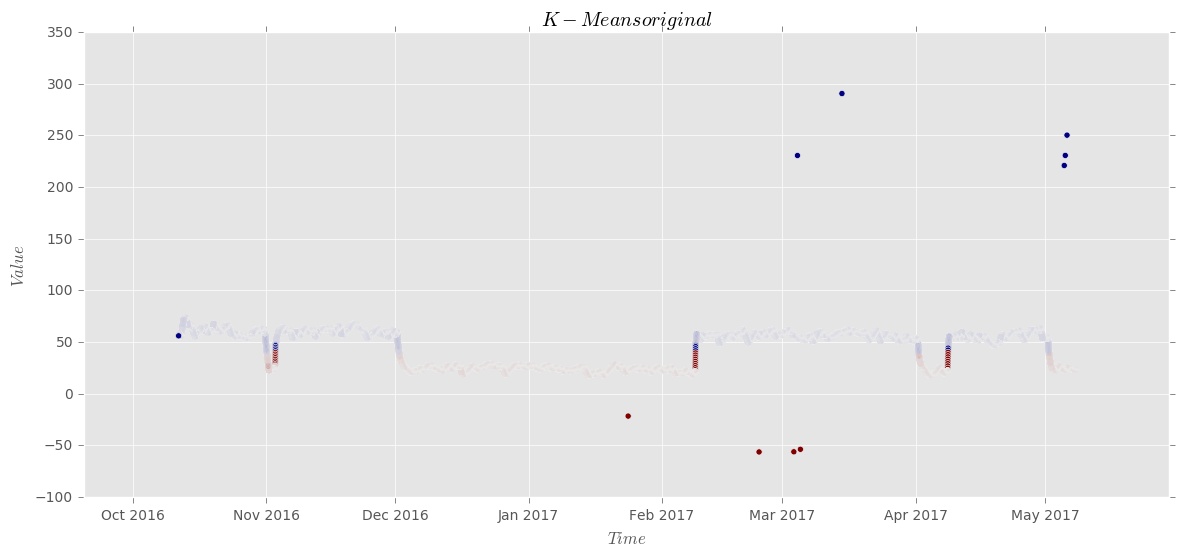

k =  3
centroids  : [ 23.95503738]
num of data points in cluster 0  :  8043        percent:  0.4022706812043613
[[11946  8039]
 [    5     4]]
Accuracy :  0.597679303791
Error    :  0.402320696209
-------------------------------------------------
centroids  : [ 57.5651636]
num of data points in cluster 1  :  11946        percent:  0.5974792437731319
[[ 8039 11946]
 [    9     0]]
Accuracy :  0.402070621186
Error    :  0.597929378814
-------------------------------------------------
centroids  : [ 244.44302292]
num of data points in cluster 2  :  5        percent:  0.00025007502250675204
[[19985     0]
 [    4     5]]
Accuracy :  0.999799939982
Error    :  0.000200060018005
-------------------------------------------------


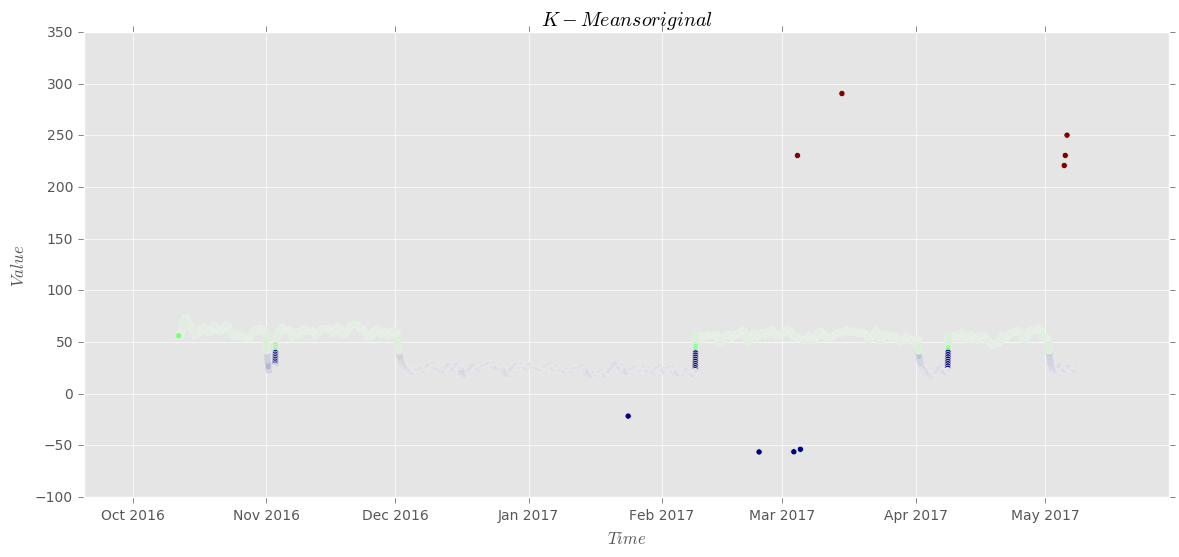

k =  4
centroids  : [ 61.03845416]
num of data points in cluster 0  :  5753        percent:  0.2877363208962689
[[14232  5753]
 [    9     0]]
Accuracy :  0.711813544063
Error    :  0.288186455937
-------------------------------------------------
centroids  : [ 23.91732012]
num of data points in cluster 1  :  8024        percent:  0.40132039611883563
[[11965  8020]
 [    5     4]]
Accuracy :  0.598629588877
Error    :  0.401370411123
-------------------------------------------------
centroids  : [ 244.44302292]
num of data points in cluster 2  :  5        percent:  0.00025007502250675204
[[19985     0]
 [    4     5]]
Accuracy :  0.999799939982
Error    :  0.000200060018005
-------------------------------------------------
centroids  : [ 54.2944312]
num of data points in cluster 3  :  6212        percent:  0.3106932079623887
[[13773  6212]
 [    9     0]]
Accuracy :  0.688856656997
Error    :  0.311143343003
-------------------------------------------------


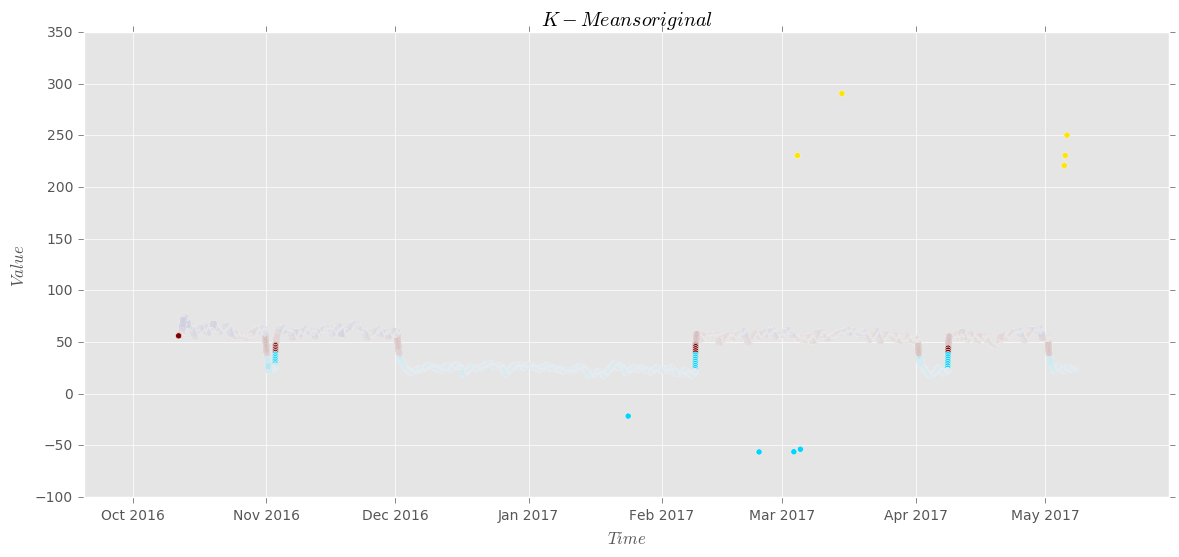

k =  5
centroids  : [ 26.3231133]
num of data points in cluster 0  :  4121        percent:  0.20611183355006502
[[15864  4121]
 [    9     0]]
Accuracy :  0.793438031409
Error    :  0.206561968591
-------------------------------------------------
centroids  : [ 61.16848819]
num of data points in cluster 1  :  5540        percent:  0.2770831249374812
[[14445  5540]
 [    9     0]]
Accuracy :  0.722466740022
Error    :  0.277533259978
-------------------------------------------------
centroids  : [ 21.61205621]
num of data points in cluster 2  :  3920        percent:  0.1960588176452936
[[16069  3916]
 [    5     4]]
Accuracy :  0.80389116735
Error    :  0.19610883265
-------------------------------------------------
centroids  : [ 244.44302292]
num of data points in cluster 3  :  5        percent:  0.00025007502250675204
[[19985     0]
 [    4     5]]
Accuracy :  0.999799939982
Error    :  0.000200060018005
-------------------------------------------------
centroids  : [ 54.44988992]
nu

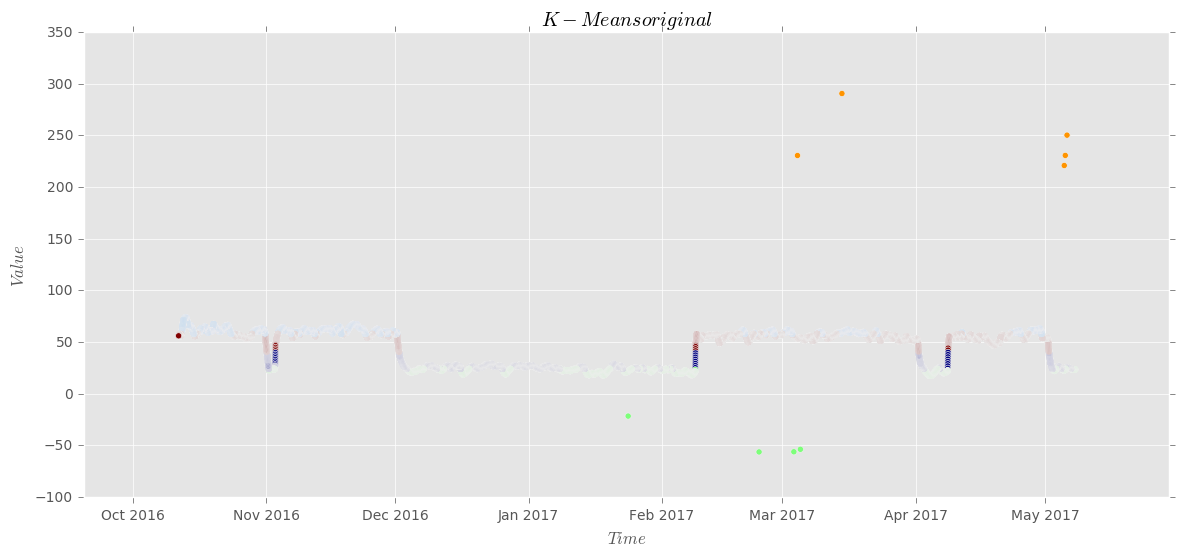

k =  6
centroids  : [ 57.36526952]
num of data points in cluster 0  :  5202        percent:  0.2601780534160248
[[14783  5202]
 [    9     0]]
Accuracy :  0.739371811543
Error    :  0.260628188457
-------------------------------------------------
centroids  : [ 25.82745654]
num of data points in cluster 1  :  4783        percent:  0.239221766529959
[[15202  4783]
 [    9     0]]
Accuracy :  0.76032809843
Error    :  0.23967190157
-------------------------------------------------
centroids  : [ 244.44302292]
num of data points in cluster 2  :  5        percent:  0.00025007502250675204
[[19985     0]
 [    4     5]]
Accuracy :  0.999799939982
Error    :  0.000200060018005
-------------------------------------------------
centroids  : [ 52.44077825]
num of data points in cluster 3  :  3186        percent:  0.15934780434130238
[[16799  3186]
 [    9     0]]
Accuracy :  0.840202060618
Error    :  0.159797939382
-------------------------------------------------
centroids  : [ 62.42491889]
nu

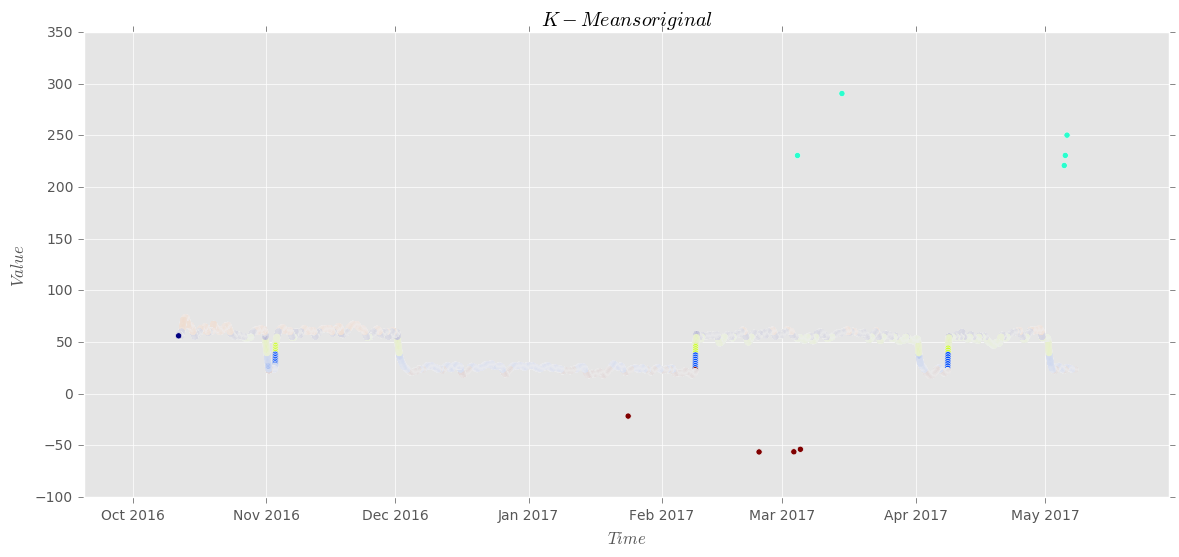

k =  7
centroids  : [ 21.39884052]
num of data points in cluster 0  :  3688        percent:  0.1844553366009803
[[16301  3684]
 [    5     4]]
Accuracy :  0.815494648395
Error    :  0.184505351605
-------------------------------------------------
centroids  : [ 55.66602231]
num of data points in cluster 1  :  5006        percent:  0.2503751125337601
[[14979  5006]
 [    9     0]]
Accuracy :  0.749174752426
Error    :  0.250825247574
-------------------------------------------------
centroids  : [ 50.58561512]
num of data points in cluster 2  :  1542        percent:  0.07712313694108232
[[18443  1542]
 [    9     0]]
Accuracy :  0.922426728018
Error    :  0.0775732719816
-------------------------------------------------
centroids  : [ 65.44919521]
num of data points in cluster 3  :  1015        percent:  0.05076522956887066
[[18970  1015]
 [    9     0]]
Accuracy :  0.948784635391
Error    :  0.0512153646094
-------------------------------------------------
centroids  : [ 244.44302292]


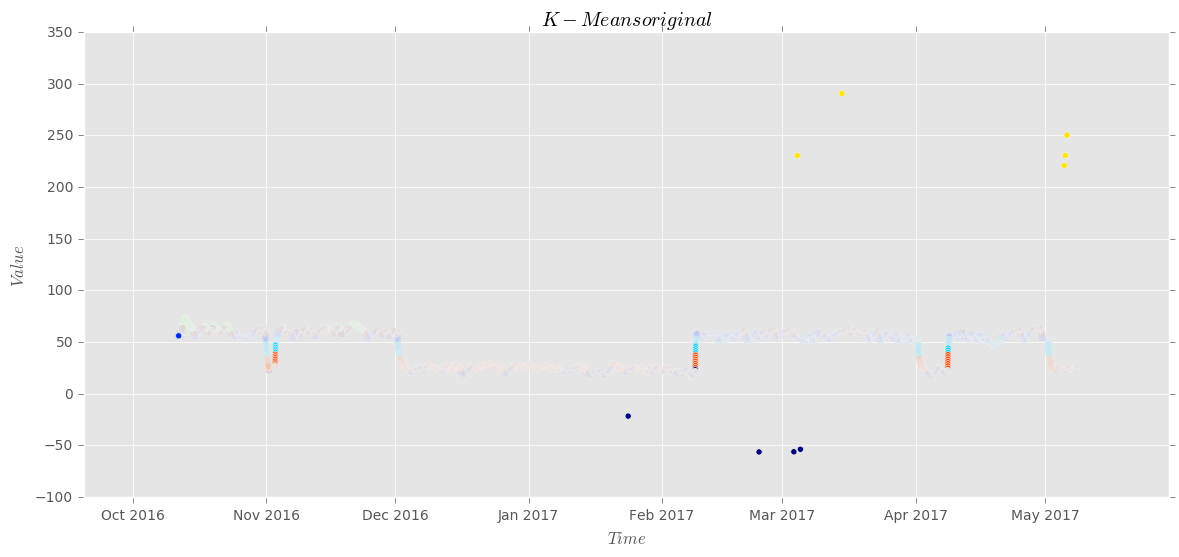

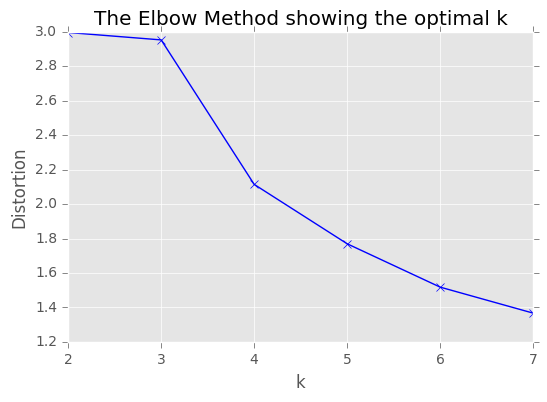

In [261]:
# k means Original
distortions = []
K = range(2,8)
values = np.asarray(rowValues).reshape(-1, 1)
dates = np.asarray(rowDates)
#--------------- 
#datesNew = rowDates.copy()
#valuesNew = rowValues.copy()
#del datesNew[0]
#del valuesNew[0]
#---------------
    
for k in K:
    print ('k = ' , k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])     
    
    centroids = kmeanModel.cluster_centers_
    
    labels = kmeanModel.labels_
    
    labelsNew = list(labels) 

    counts = []
    outlierValuesPredictedCluster = []

    
    for cluster in range(0,k):
        counter = 0
        outlierValuesPredicted = []
        
        for label in (labels):
            if (cluster == label):
                counter = counter + 1
                outlierValuesPredicted.append(1)
            else:
                outlierValuesPredicted.append(0)
                continue
        counts.append(counter)
        outlierValuesPredictedCluster.append(outlierValuesPredicted)

    for i in range(len(counts)):
        print("centroids " , ":" , centroids[i])
        print('num of data points in cluster', i ,' : ', counts[i],'       percent: ' ,  counts[i]/len(values)) 
        cm = confusion_matrix(outlier, outlierValuesPredictedCluster[i])
        print(cm)
        acc = calculateAccuracy(cm)
        err = calculateError(cm)
        print("Accuracy : ", acc)
        print("Error    : " ,err)
        print("-------------------------------------------------")
        
        #plotTheDataWithoutClusters(i, labelsNew, valuesNew, datesNew, "without cluster")

    
    plotTheclusteredData(rowDates, rowValues, labels)
        

plotTheElbow(K, distortions)


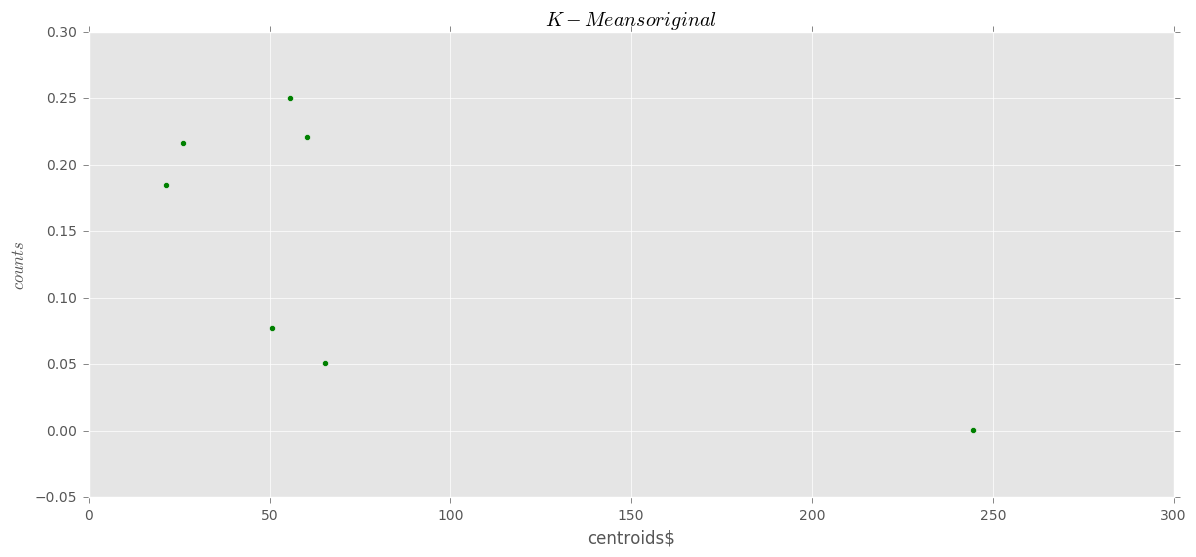

"\n\nn, bins, patches = plt.bar(centroids)\n\n\nplt.xlabel('Smarts')\nplt.ylabel('Probability')\nplt.title('Histogram of IQ')\nplt.show()\n"

In [262]:
fig, (ax1) = plt.subplots(1, figsize=(14,6))

ax1.scatter(centroids, [i/len(rowValues) for i in counts], c="green")
ax1.set_xlabel("centroids$")
ax1.set_ylabel("$counts$")

ax1.set_title("$K-Means original$")
plt.show()


'''

n, bins, patches = plt.bar(centroids)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.show()
'''

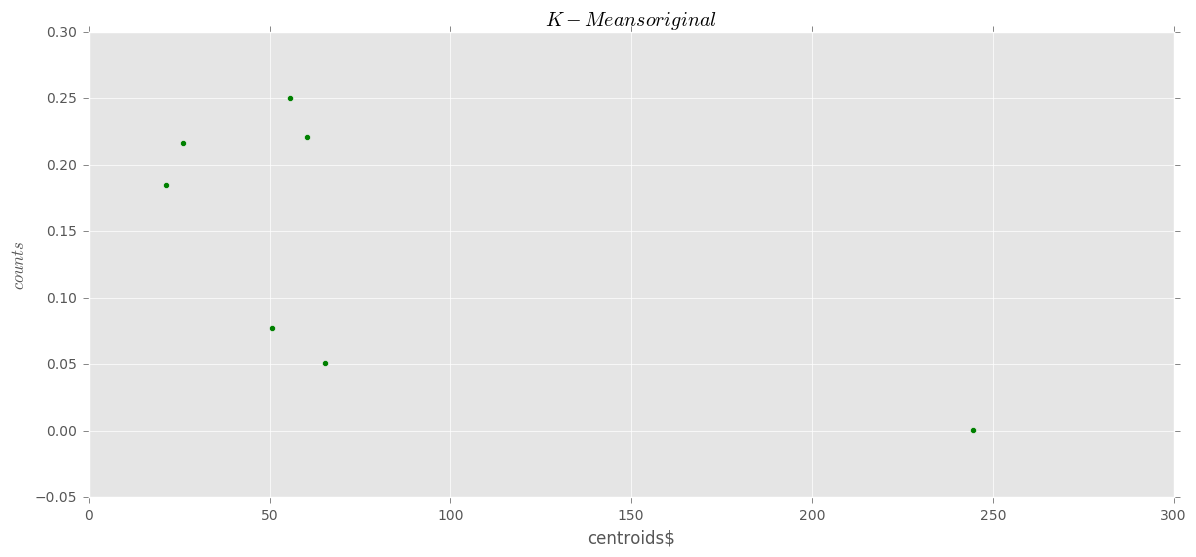

In [263]:
fig, (ax1) = plt.subplots(1, figsize=(14,6))

ax1.scatter(centroids, [i/len(rowValues) for i in counts], c="green")
ax1.set_xlabel("centroids$")
ax1.set_ylabel("$counts$")

ax1.set_title("$K-Means original$")
plt.show()

[21.398840521155499, 3688]
[55.666022305105123, 5006]
[50.585615115392976, 1542]
[65.449195213468357, 1015]
[244.44302291599999, 5]
[26.050156051581961, 4326]
[60.274290636935419, 4412]
7
k =  2
centroids  = [   40.84732738  4358.        ]
num of data points in cluster 0  :  4        percent:  0.5714285714285714
-------------------------------------------------
centroids  = [ 120.15927775  854.        ]
num of data points in cluster 1  :  3        percent:  0.42857142857142855
-------------------------------------------------


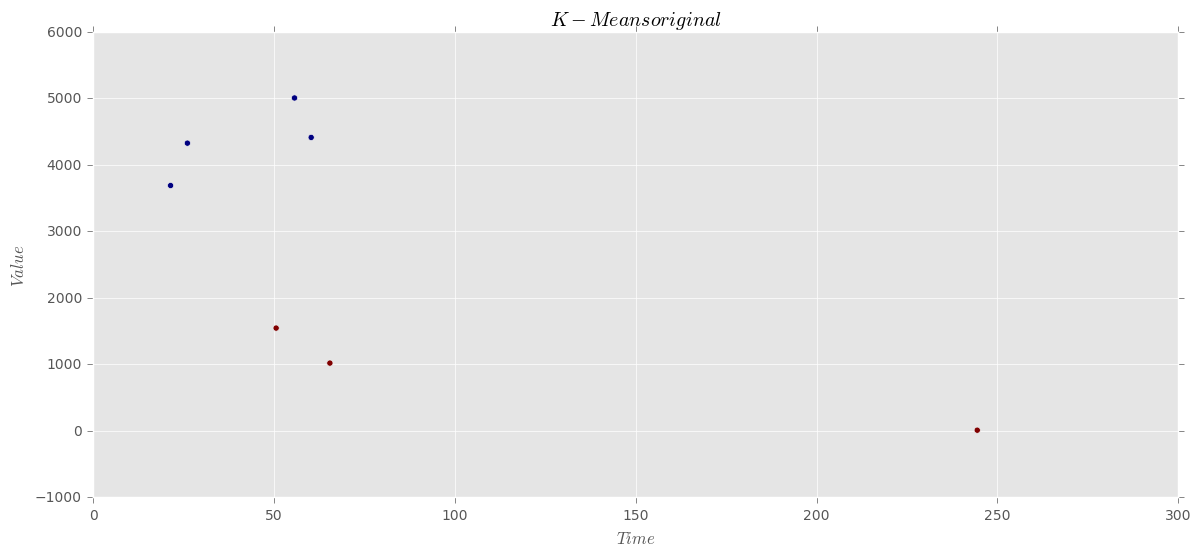

k =  3
centroids  = [   58.01740516  1278.5       ]
num of data points in cluster 0  :  2        percent:  0.2857142857142857
-------------------------------------------------
centroids  = [   40.84732738  4358.        ]
num of data points in cluster 1  :  4        percent:  0.5714285714285714
-------------------------------------------------
centroids  = [ 244.44302292    5.        ]
num of data points in cluster 2  :  1        percent:  0.14285714285714285
-------------------------------------------------


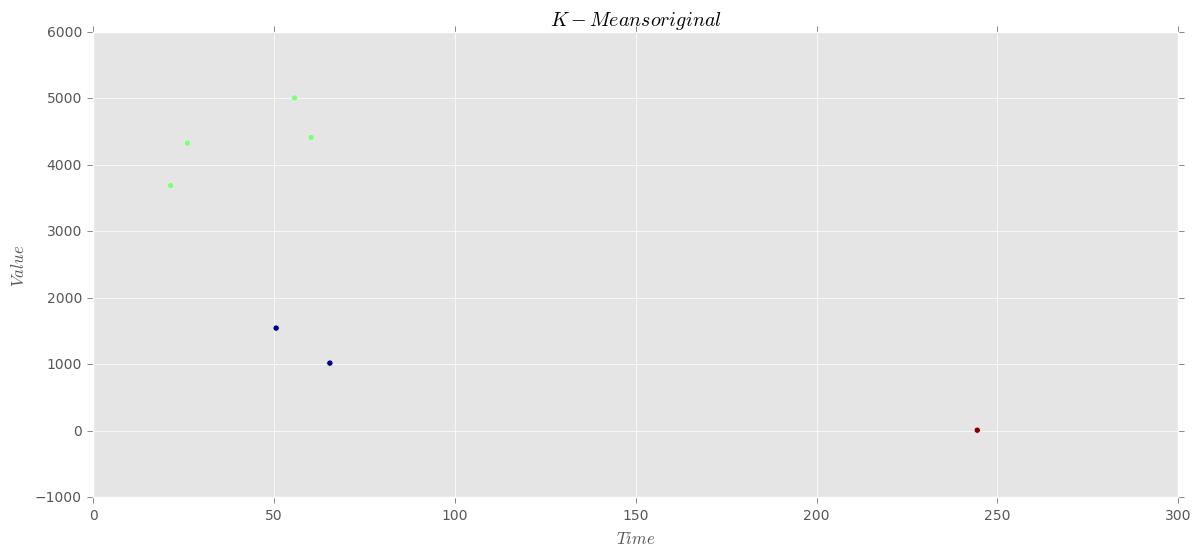

ValueError: x and y can be no greater than 2-D

In [264]:
# k means Original
distortions = []
K = range(2,4)
zipped = []
values = np.asarray(centroids).reshape(-1, 1)
dates = np.asarray(counts)
values =list(values)
for i in range(len(values)):
    vec = []
    vec.append(values[i][0])
    vec.append(dates[i])
    print(vec)
    zipped.append(vec)
    
zipped = np.asarray(zipped)
print(zipped.shape[0])

for k in K:
    print ('k = ' , k)
    #kmeanModel = KMeans(n_clusters=k).fit(zipped)
    #distortions.append(sum(np.min(cdist(zipped.reshape(-1, 1), 
    #            kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / zipped.shape[0])     
    
    
    kmeanModel = KMeans(n_clusters=k).fit(zipped)
    distortions.append(sum(np.min(cdist(zipped, 
                            kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / zipped)     
    
    
    centroids = kmeanModel.cluster_centers_
    
    labels = kmeanModel.labels_
    
    labelsNew = list(labels) 

    counts = []
    outlierValuesPredictedCluster = []

    
    for cluster in range(0,k):
        counter = 0
        outlierValuesPredicted = []
        
        for label in (labels):
            if (cluster == label):
                counter = counter + 1
                outlierValuesPredicted.append(1)
            else:
                outlierValuesPredicted.append(0)
                continue
        counts.append(counter)
        outlierValuesPredictedCluster.append(outlierValuesPredicted)

    for i in range(len(counts)):
        print("centroids " , "=" , centroids[i])
        print('num of data points in cluster', i ,' : ', counts[i],'       percent: ' ,  counts[i]/len(values)) 
        #print(confusion_matrix(outlier, outlierValuesPredictedCluster[i]))
        print("-------------------------------------------------")
    
    plotTheclusteredData(values, dates, labels)

plotTheElbow(K, distortions)


In [ ]:
# k means delta
distortions = []
K = range(2,3)
values = np.asarray(deltaValues).reshape(-1, 1)
dates = np.asarray(deltaDates)

rowValuesNew = rowValues.copy()
rowDatesNew = rowDates.copy()

del rowValuesNew[0]
del rowDatesNew[0]


for k in K:
    print ('k = ' , k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])     
    
    centroids = kmeanModel.cluster_centers_
    
    labels = kmeanModel.labels_
    
    labelsNew = list(labels) 

    counts = []
    outlierValuesPredictedCluster = []

    
    for cluster in range(0,k):
        counter = 0
        outlierValuesPredicted = []
        
        for label in (labels):
            if (cluster == label):
                counter = counter + 1
                outlierValuesPredicted.append(1)
            else:
                outlierValuesPredicted.append(0)
                continue
        counts.append(counter)
        outlierValuesPredictedCluster.append(outlierValuesPredicted)

    for i in range(len(counts)):
        print("centroids " , "=" , centroids[i])
        print('num of data points in cluster', i ,' : ', counts[i],'       percent: ' ,  counts[i]/len(values)) 
        print(confusion_matrix(outlierDelta, outlierValuesPredictedCluster[i]))
        print("-------------------------------------------------")
    
    plotTheclusteredData(rowDatesNew, rowValuesNew, labels)
plotTheElbow(K, distortions) 


In [ ]:
# k means Posdelta
distortions = []
K = range(2,6)
values = np.asarray(posDeltaValues).reshape(-1, 1)
dates = np.asarray(deltaDates)
rowValuesNew = rowValues.copy()
rowDatesNew = rowDates.copy()

del rowValuesNew[0]
del rowDatesNew[0]

for k in K:
    print ('k = ' , k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])     
    
    centroids = kmeanModel.cluster_centers_
    
    labels = kmeanModel.labels_
    
    labelsNew = list(labels) 

    counts = []
    outlierValuesPredictedCluster = []

    
    for cluster in range(0,k):
        counter = 0
        outlierValuesPredicted = []
        
        for label in (labels):
            if (cluster == label):
                counter = counter + 1
                outlierValuesPredicted.append(1)
            else:
                outlierValuesPredicted.append(0)
                continue
        counts.append(counter)
        outlierValuesPredictedCluster.append(outlierValuesPredicted)

    for i in range(len(counts)):
        print("centroids " , "=" , centroids[i])
        print('num of data points in cluster', i ,' : ', counts[i],'       percent: ' ,  counts[i]/len(values)) 
        #print(len(outlierValues['values']))
        #print(len(outlierValuesPredictedCluster[i]))
        print(confusion_matrix(outlierDelta, outlierValuesPredictedCluster[i]))
        print("-------------------------------------------------")

    plotTheclusteredData(rowDatesNew, rowValuesNew, labels)    
plotTheElbow(K, distortions) 


### finish

### positive increases 

In [ ]:
# k means Original
distortions = []
K = range(2,15)

for k in K:
    print ('k = ' , k)
    kmeanModel = KMeans(n_clusters=k).fit(posIncreases['values'].reshape(-1, 1))
    kmeanModel.fit(posIncreases['values'].reshape(-1, 1))
    distortions.append(sum(np.min(cdist(posIncreases['values'].reshape(-1, 1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / posIncreases['values'].reshape(-1, 1).shape[0])     
    
    centroids = kmeanModel.cluster_centers_
    
    labels = kmeanModel.labels_
    
    labelsNew = list(labels) 

    counts = []
    outlierValuesPredictedCluster = []

    
    for cluster in range(0,k):
        counter = 0
        outlierValuesPredicted = []
        
        for label in (labels):
            if (cluster == label):
                counter = counter + 1
                outlierValuesPredicted.append(1)
            else:
                outlierValuesPredicted.append(0)
                continue
        counts.append(counter)
        outlierValuesPredictedCluster.append(outlierValuesPredicted)

    for i in range(len(counts)):
        print("centroids " , "=" , centroids[i])
        print('num of data points in cluster', i ,' : ', counts[i],'       percent: ' ,  counts[i]/len(posIncreases['values']) ) 
        #print(len(outlierValues['values']))
        #print(len(outlierValuesPredictedCluster[i]))
        print(confusion_matrix(outlierPosIncrease, outlierValuesPredictedCluster[i]))
        print("-------------------------------------------------")

    fig, (ax1) = plt.subplots(1, figsize=(14,6))
    ax1.scatter(list(posIncreases['dates']), list(posIncreases['values']) , c=labels.astype(np.float))
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.set_title("$K-Means original$")
    plt.show()
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### K means for Original 

In [ ]:
# k means Original
distortions = []
K = range(2,8)
values = np.asarray(rowValues).reshape(-1, 1)
dates = np.asarray(rowDates)
 
for k in K:
    print ('k = ' , k)
    kmeanModel = KMeans(n_clusters=k).fit(values)
    distortions.append(sum(np.min(cdist(values.reshape(-1, 1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / values.shape[0])     
    
    centroids = kmeanModel.cluster_centers_
    
    labels = kmeanModel.labels_
    
    labelsNew = list(labels) 

    counts = []
    outlierValuesPredictedCluster = []

    
    for cluster in range(0,k):
        counter = 0
        outlierValuesPredicted = []
        
        for label in (labels):
            if (cluster == label):
                counter = counter + 1
                outlierValuesPredicted.append(1)
            else:
                outlierValuesPredicted.append(0)
                continue
        counts.append(counter)
        outlierValuesPredictedCluster.append(outlierValuesPredicted)

    for i in range(len(counts)):
        print("centroids " , "=" , centroids[i])
        print('num of data points in cluster', i ,' : ', counts[i],'       percent: ' ,  counts[i]/len(values)) 
        #print(len(outlierValues['values']))
        #print(len(outlierValuesPredictedCluster[i]))
        print(confusion_matrix(outlier, outlierValuesPredictedCluster[i]))
        print("-------------------------------------------------")

    fig, (ax1) = plt.subplots(1, figsize=(14,6))
    ax1.scatter(rowDates, rowValues , c=labels.astype(np.float))
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.set_title("$K-Means original$")
    plt.show()
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### K means for Increase 

In [ ]:
# k means increase and original
distortionsOri = []
distortionsInc = []

K = range(2,15)
for k in K:
    print ('k = ', k)
    kmeanModel = KMeans(n_clusters=k).fit(Xoriginal['values'].reshape(-1, 1))
    kmeanModelInc = KMeans(n_clusters=k).fit(Xincreases['values'].reshape(-1, 1))
    
    kmeanModel.fit(Xoriginal['values'].reshape(-1, 1))
    kmeanModelInc.fit(Xincreases['values'].reshape(-1, 1))
    
    distortionsOri.append(sum(np.min(cdist(Xoriginal['values'].reshape(-1, 1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Xoriginal['values'].reshape(-1, 1).shape[0])     
    distortionsInc.append(sum(np.min(cdist(Xincreases['values'].reshape(-1, 1), kmeanModelInc.cluster_centers_, 'euclidean'), axis=1)) / Xincreases['values'].reshape(-1, 1).shape[0])     

    centroidsORig = kmeanModel.cluster_centers_
    centroidsInc = kmeanModelInc.cluster_centers_

    labelsOrig = kmeanModel.labels_
    labelsInc = kmeanModelInc.labels_

    labelsNewOrig = list(labelsOrig) 
    labelsNewInc = list(labelsInc) 

    for i in centroidsORig:
        print("centroids Original " , "=" , i)
    
    for i in centroidsInc:
        print("centroids Increases " , "=" , i)
    
    countsOri = []
    countsInc = []

    for cluster in range(0,k):
        counter1 = 0
        counter2 = 0
        for label in (labelsOrig):
            if (cluster == label):
                counter1 = counter1+1
            else:
                continue
        for label in (labelsInc):
            if (cluster == label):
                counter2 = counter2+1
            else:
                continue
        countsOri.append(counter1)
        countsInc.append(counter2)

    for i in (countsOri):
        print('num of original data points: ', i,'       percent: ' ,  i/len(Xoriginal['values']) ) 

    for i in (countsInc):
        print('num of Increase data points: ', i,'       percent: ' ,  i/len(Xincreases['values']) ) 

    fig, (ax1) = plt.subplots(1, figsize=(14,6))
    ax1.scatter(list(Xoriginal['dates']), list(Xoriginal['values']) , c=labelsOrig.astype(np.float))
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.set_title("$K-Means original$")
    plt.show()
 

    fig, (ax1) = plt.subplots(1, figsize=(14,6))
    ax1.scatter(list(Xincreases['dates']), list(Xincreases['values']) , c=labelsInc.astype(np.float))
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.set_title("$K-Means increases$")
    plt.show()

    
# Plot the elbow
plt.plot(K, distortionsOri, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Plot the elbow
plt.plot(K, distortionsInc, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [ ]:
cluster_num = 5
counts = []

kmeans3 = KMeans(n_clusters=cluster_num)
kmeans3.fit(Xnew3['values'].reshape(-1, 1))

centroids = kmeans3.cluster_centers_
labels = kmeans3.labels_

labelsNew = list(labels) 

for i in range(len(labelsNew)):
    if (labelsNew[i] != 0):
        print(dates[i])

for i in centroids:
    print("centroids " , "=" , i)


for cluster in range(cluster_num):
    counter = 0
    for label in (labels):
        if (cluster == label):
            counter = counter + 1
        else:
            continue
    counts.append(counter)

for i in counts:
    print(i,'       ' , i/len(series) ) 

         
fig, (ax1) = plt.subplots(1, figsize=(14,6))
ax1.scatter(list(Xnew3['dates']), list(Xnew3['values']) , c=labels.astype(np.float))
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_title("K-Means with $k=3$ increases")
plt.show()

In [ ]:
cluster_num = 5
counts = []

kmeans4 = KMeans(n_clusters=cluster_num)
kmeans4.fit(Xnew4['values'].reshape(-1, 1))

centroids = kmeans4.cluster_centers_
labels = kmeans4.labels_

for i in list(labels):
    if (i == 4):
        print(list(labels))

print(type(labels))

for i in (centroids):
    print("centroids " , "=" , i)

for cluster in range(cluster_num):
    counter = 0
    for label in (labels):
        if (cluster == label):
            counter = counter+1
        else:
            continue
    counts.append(counter)

for i in counts:
    print(i,'       ' , i/len(series) )     
    
fig, (ax2) = plt.subplots(1, figsize=(14,6))
ax2.scatter(list(Xnew4['dates']), list(Xnew4['values']) , c=labels.astype(np.float))
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_title("K-Means with $k=5 Orinigal")
plt.show()




In [ ]:
cluster_num = 7

kmeans4 = KMeans(n_clusters=cluster_num)
kmeans4.fit(Xnew4['values'].reshape(-1, 1))

centroids = kmeans4.cluster_centers_
labels = kmeans4.labels_

for i in (centroids):
    print("centroids " , "=" , i)

fig, (ax2) = plt.subplots(1, figsize=(14,6))
ax2.scatter(list(Xnew4['dates']), list(Xnew4['values']) , c=labels.astype(np.float))
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_title("K-Means with $k=4$")
plt.show()

In [ ]:
cluster_num = 3

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(X.reshape(-1, 1))

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print ("centroids : ")
print (centroids)
print ("labels : ")
print (labels)

colors = ["g.","r.","c.","y."]

color = ["g", "r", "b"]

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')


for i in range(len(X)):
    print("coordinate:",X[i], "label:", labels[i])
    print ("i : ",i)
    print ("color[labels[i]] : ",color[labels[i]])
    ax.scatter(i, values[i], c=color[labels[i]])

for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 1],centroids[:, 2], centroids[:, ], marker = "x", s=150, linewidths = 5, zorder = 100, c=color)
plt.show()

In [ ]:
n_clusters=3
kmeans = KMeans(n_clusters).fit(series.reshape(-1, 1))


centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print ("centroids : ")
print (centroids)
print ("labels : ")
print (labels)

colors = ["g.","r.","c.","y."]

color = ["g", "r", "b"]
c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')


for i in range(len(series)):
    #print('series[i] ',series[:i])
    print("coordinate:",series[i], "label:", labels[i])
    print ("i : ",i)
    print ("color[labels[i]] : ",color[labels[i]])
    ax.scatter(i, values[i], c=color[labels[i]])

for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[0],centroids[1], marker = "x", s=150, linewidths = 5, zorder = 100, c=color)

plt.show()

In [ ]:
plt.figure(figsize=(14,7))
idx = pd.IndexSlice 
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])
 
# Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.scatter(x=len(series.iloc[idx[:,0]]), y=len(series.iloc[idx[:,1]]))
plt.title('Real Classification')
 
# Plot the Models Classifications
#plt.subplot(1, 2, 2)
#plt.scatter(dataFrame.Petal_Length, dataFrame.Petal_Width, c=colormap[model.labels_], s=40)
#plt.title('K Mean Classification')

In [ ]:
df = pd.read_csv('temperator.txt')
data = [plt.scatter( x=len(df.iloc[:,0]), y=len(df.iloc[:,1]))]

py.iplot(data, filename='pandas-time-series')

In [ ]:
dates = []
values = []
increases = []
posIncreases = []
outlierValues = []
outlierIncrease = []
outlierPosIncrease = []
outlierDates = []
increases = []
posIncreases = []

counter = 0
#dataDF = pd.read_csv('CW PUMP 1B CURRENT.csv', sep=',', header=None)  
#dataDF = pd.read_csv('ID FAN 1B MTR OBRG TEMP.csv', sep=',', header=None)       # outlier > 90 and < 10
#dataDF = pd.read_csv('temperator.csv', sep=',', header=None)                   # outlier > 100 and < 0 
dataDF = pd.read_csv('9-1-2008 to 9-1-2009 Trend.csv', sep=',', header=None)  

DF = pd.DataFrame() 

for index, row in dataDF.iterrows():
    value = row[1]
    date = row[0]
    try:
        float(value)
        value.isdigit()
        dates.append(pd.to_datetime(date))
        values.append(float(value))
        if(float(value) > 100 or float(value) < 0):
            outlierValues.append(float(1))
        else: 
            outlierValues.append(float(0))
        outlierDates.append(pd.to_datetime(date))   
                
        if(len(values) > 1):
            increase = values[len(values)-2] - values[len(values)-1]
            
            if(float(-1 * increase) > 150):
                outlierPosIncrease.append(1)
            else :
                outlierPosIncrease.append(0)
            if(increase > 150 or increase < -150):
                outlierIncrease.append(1)
            else: 
                outlierIncrease.append(0)
            
            increases.append(increase)
            if (increase < 0):
                posIncreases.append(float(-1 * increase))
            else:
                posIncreases.append(increase)        
                        
    except:
        counter += 1
        continue
    if index == 50000:
        break

datesInc = dates[:]
outlierDatesInc =  outlierDates[:]

del datesInc[0]
del outlierDatesInc[0]


Xoriginal = pd.DataFrame({'dates':dates, 'values':values})
increases= pd.DataFrame({'dates': datesInc, 'values':increases})
posIncreases= pd.DataFrame({'dates': datesInc, 'values':posIncreases})


print('original val   :',len(values))
print('original dates :',len(dates))
print('outlierValues :',len(outlierValues))
print('outlierDates :',len(outlierDates))
print("------------------")
print('increases val :',len(increases))
print('datesInc :',len(datesInc))
print('outlierIncrease :',len(outlierIncrease))
print('outlierDates :',len(outlierDatesInc))
print("------------------")
print('posIncreases :',len(posIncreases))
print('datesInc :',len(datesInc))
print('outlierPosIncrease :',len(outlierPosIncrease))
print('outlierDates :',len(outlierDatesInc))
print("------------------")